In [1]:
dataset = 'hatespeech'

In [2]:
import os
import pandas as pd
import random
import numpy as np
import re

In [3]:
SEED = 1
# REPEATABILITY
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
seed_everything()

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):
    x = str(x)
    for punct in puncts:
        if punct in x: # comparison makes faster
            x = x.replace(punct, f' {punct} ')
    return x

quotes = ['″', '′', '"'] # apostrophe "'"
def mark_quotes(x):
    x = str(x)
    for quote in quotes:
        if quote in x: # comparison makes faster
            x = x.replace(quote, f'quote')
    return x

def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    
    mention_regex = '@[\w\-]+'
    
    #add #, mention, e.g. &#8120     
    mention_regex2  =   '&#[0-9]*' 
    
    
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, ' URL ', parsed_text)
    parsed_text = re.sub(mention_regex, ' MENTION', parsed_text)
    parsed_text = re.sub(mention_regex2, ' MENTION', parsed_text)    
    return parsed_text


def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    
    # *needed to be removed or outputs a list of letters
    #tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    tweet = " ".join(re.split("[^a-zA-Z.,!?]", tweet.lower())).strip()  
    #tweet = " ".join(re.split(r'\s+', tweet.lower())).strip()
    return tweet.split()

In [4]:
current = os.getcwd()
basefolder = current + '/dataset_'+ dataset+'/'
datafolder = basefolder + 'data/'  # for example /dataset_businessnews/data/
print(datafolder)

infolder =  basefolder + 'input/'
outfolder = basefolder + 'output/'

/home/max/git/modelcompare/dataset_hatespeech/data/


In [5]:
datafile = datafolder + 'labeled_data.csv'
datafile

'/home/max/git/modelcompare/dataset_hatespeech/data/labeled_data.csv'

In [6]:
# count: nr of users who coded item
# middle: nr who coded as hate speech / offecinve / neither
# class: majority label of users 
#  0 - hate speech
#  1 - ONLY offensive  language
#  2 - neither

mydata = pd.read_csv(datafile, index_col=0)
mydata.head(4)

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...


In [7]:
len(mydata)

24783

In [8]:
# pick 2 columns, class and tweet, rename them to label, text
df = mydata[['class', 'tweet']]
df.columns = ['label', 'text']
df.head()


,label,text
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [9]:
# Randomize data
np.random.seed(SEED)
trn_idx = np.random.permutation(len(df))
df = df.iloc[trn_idx]

In [10]:
# Preprocess

In [11]:
df.text = df.text.apply(lambda x: preprocess(x)) #URL, @mention etc
df["text"] = df["text"].apply(lambda x: clean_text(x))
df["text"] = df["text"].apply(lambda x: mark_quotes(x))
#df.text = df.text.apply(lambda x: basic_tokenize(x))

df.head(4)

,label,text
14272,1,Pumpkin spice Marlboro ' s for da hoes
1671,1,MENTION ; MENTION : What things do you love...
23584,2,Yankees should have NEVER gave away Melky . G...
3591,1,MENTION I love Louis CK ! Quit bein a faggot...


### Write data with minimal preprosessing out to one file

In [12]:
df.to_csv(basefolder+'input/alldata.csv',sep='\t', index = False, header = False)

In [13]:
# add index as own column to keep track of each items id
df = df.reset_index()

### Train,dev,test split by strafity (keep ratio of classes)

In [14]:
# sklearn train_test_split can take parameters X, y  or df, test_size or train_size, as float(percentage)
# or as int(number), stratify maintains class ratio

from sklearn.model_selection import train_test_split
train, test = train_test_split(df, stratify=df['label'], train_size=3000)
                                              

In [15]:
print(len(train))
print(len(test))

3000
21783


In [16]:
test

,index,label,text
17101,9144,2,Dumpster RT MENTION : Gahbage RT MENTION : ...
13957,2341,2,MENTION Charlie Sheen could coach better than...
4513,24140,1,"bitch with all niggas , hmmm she either gay o..."
19009,4069,0,"MENTION Yeah ! Me too . My people , the wo..."
12726,25029,2,"the rams really dont wanna be trash , jeff fi..."
...,...,...,...
14813,19507,1,RT MENTION : Cleveland nigga I ' m fly We sw...
750,12214,0,"It was nice of you to unfollow me , fag"
12891,21128,1,Sendin the link to Wishy Washy to my old hoes
5716,24786,1,no need to be a bitch .


In [17]:
# basic split, not keeping class ratio

size = len(df)
dev_size = 3000
test_size = 3000

train = df[0 : size - test_size - dev_size]
dev = df[size - test_size - dev_size : size-test_size]
test = df[size-test_size : size]


#train.to_json('input/train.json', orient='records', lines=True)
#val.to_json('input/val.json', orient='records', lines=True)
#test.to_json('input/test.json', orient='records', lines=True)

train.to_csv(basefolder+'input/train.csv',sep='\t', index = False, header = False)
dev.to_csv(basefolder+'input/dev.csv'  ,sep='\t', index = False, header = False)
test.to_csv(basefolder+'input/test.csv',sep='\t', index = False, header = False)

In [18]:
len(train)

18783

In [19]:
len(dev)

3000

In [20]:
len(test)

3000

In [21]:
test.head()

,index,label,text
21783,23437,1,Wizard turned into a hoe after a break up
21784,17813,1,RT MENTION : Captain Kirk hoe !
21785,2561,1,MENTION bruh did go out like a bitch thoe lol...
21786,18228,1,RT MENTION : RT MENTION : when you tryna g...
21787,23030,1,Well I wish I could shoot the shit wit u bitch...


### print info about data

In [23]:
# Counts, Majority

# 0 - hate speech
# 1 - offensive language
# 2 - neither

from collections import Counter
c = Counter(df['label'])
c


Counter({1: 19190, 2: 4163, 0: 1430})

In [24]:
from collections import Counter
c = Counter(df['label'])

s = sum(c.values())
for elem, count in c.items():
      print(elem, count / s)

1 0.7743211072105879
2 0.16797804946939435
0 0.05770084332001776


In [25]:
# use seaborn background for plot
import seaborn as sns
sns.set()

#sns.axes_style("whitegrid")
sns.set_style("whitegrid")


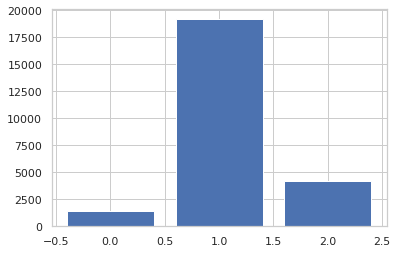

In [26]:
import collections
import matplotlib.pyplot as plt

plt.bar(c.keys(), c.values())
plt.show()

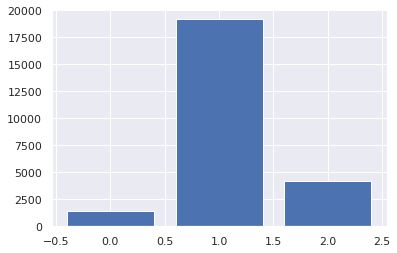

In [29]:
sns.set_style("darkgrid")

#sns.set_style("ticks")
#sns.set()
plt.bar(c.keys(), c.values())
plt.show()